In [62]:
import networkx as nx
from networkx.algorithms import community # ~louvain
import community as community_louvain # python louvain
import itertools
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cdlib as cd
from cdlib import algorithms
from cdlib import evaluation
# Fonts for plots
#mpl.rcParams['font.serif'] = 'Times New Roman'
#plt.rcParams['font.family'] = 'serif'

pd.set_option('display.max_columns', None)

# Path to data retrieval and storage
path = "C:/Users/kleinow/ownCloud/MA_Neuro"

In [2]:
refs = pd.read_csv(path + "/cn_refs_cleaned.csv")


In [3]:
refs.head()

,item_id_citing,item_id_cited,citing_pubyear,ref_seq_nr,ref_pubyear,ref_item_title,ref_source_title,ref_authors,ref_volume,ref_pages,ref_doi,title_lower,item_id_clear
0,WOS:000086279300008,WOS:A1995RP75600044,2000,5,1995.0,MODULATION OF MEMORY FIELDS BY DOPAMINE D1 REC...,NATURE,"{""WILLIAMS, GV""}",376,572,NaN,modulation of memory fields by dopamine d1 rec...,WOS:A1995RP75600044
1,WOS:000086279300008,WOS:A1996VV46700007,2000,7,1996.0,Regional and cellular fractionation of working...,PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCE...,"{""GoldmanRakic, PS""}",93,13473,NaN,regional and cellular fractionation of working...,WOS:A1996VV46700007
2,WOS:000086279300008,WOS:A1985ARE2300019,2000,14,1985.0,PRIMATE FRONTAL EYE FIELDS .2. PHYSIOLOGICAL A...,JOURNAL OF NEUROPHYSIOLOGY,"{""BRUCE, CJ""}",54,714,NaN,primate frontal eye fields .2. physiological a...,WOS:A1985ARE2300019
3,WOS:000086279300008,WOS:A1980JC97100014,2000,15,1980.0,DISSOCIATION OF VISUAL AND SACCADE-RELATED RES...,JOURNAL OF NEUROPHYSIOLOGY,"{""MAYS, LE""}",43,207,NaN,dissociation of visual and saccade-related res...,WOS:A1980JC97100014
4,WOS:000086279300008,WOS:A1985ADU5200001,2000,16,1985.0,PRIMATE FRONTAL EYE FIELDS .1. SINGLE NEURONS ...,JOURNAL OF NEUROPHYSIOLOGY,"{""BRUCE, CJ""}",53,603,NaN,primate frontal eye fields .1. single neurons ...,WOS:A1985ADU5200001


In [4]:
# excludes nans for citing papers, otherwise there would be many cited IDs connected because of cited by NaN
refs = refs[refs["item_id_citing"].notna()] 

# cited at least 10 times
ref_counts = refs["item_id_clear"].value_counts()
refs = refs[refs["item_id_clear"].isin(ref_counts[ref_counts >= 10].index)]

In [5]:
refs_summary = pd.DataFrame({
    "Number of Rows": [len(refs)],
    "Number of Unique Citing Papers": [refs['item_id_citing'].nunique()],
    "Number of Unique Cited Papers": [refs['item_id_cited'].nunique()],
    "Number of Unique References": [refs['item_id_clear'].nunique()],
    "Earliest Pubyear": [refs['citing_pubyear'].min()],
    "Latest Pubyear": [refs['citing_pubyear'].max()],
    "Number of Unique Authors": [refs['ref_authors'].nunique()],
    "Number of Unique Journals": [refs['ref_source_title'].nunique()],
})

# For the top 10 most commonly cited references
top_10_cited = refs['item_id_clear'].value_counts().head(10).reset_index()
top_10_cited.columns = ['item_id_clear', 'Count']

In [6]:
refs_summary

,Number of Rows,Number of Unique Citing Papers,Number of Unique Cited Papers,Number of Unique References,Earliest Pubyear,Latest Pubyear,Number of Unique Authors,Number of Unique Journals
0,5857,1134,507,346,1991,2023,329,185


Average number of references cited per article

In [7]:
refs_per_citing_article = refs.groupby('item_id_citing').size()


average_refs_per_citing = refs_per_citing_article.mean() # average number of references per citing article

average_refs_per_citing # 5.164


5.1649029982363315

Implement the CoCit Value to relativize the absolute citation number in relation to the frequency of citation

In [8]:
# Define a function "gmuer" for Gmür's CoCit value:
# Formula: 
# cocit_value = (co_citations**2) / (min(citation_counts[a], citation_counts[b]) * ((citation_counts[a]+citation_counts[b])/2))
# Intuition: strength of the relationship between references A and B, 
# based on the number of co-citations and the relative citation counts of A and B

def gmuer(a_cited_by, b_cited_by): # Lists of IDs that !!!cite!!! reference A and reference B
    # Get the number of co-citations of citation A and B:
    # Where these sets of citing IDs are overlapping, the references are cited together
    # resulting set "co_citations" contains the paper IDs that cite both A and B
    """
    Calculate Gmür's Co-citation value for two references A and B.
    
    Parameters:
        a_cited_by (list): List of paper IDs that have cited reference A.
        b_cited_by (list): List of paper IDs that have cited reference B.
        
    Returns:
        cocit_value (float): The Co-citation value based on Gmür's formula.
    
    Formula:
        cocit_value = (co_citations ** 2) / (min_citations * mean_citations)
    
    Itntuition:
        The function measures the strength of the relationship between 
        references A and B based on the number of co-citations and their 
        individual citation counts.
        
        - co_citations: Number of papers that cite both A and B.
        - min_citations: Minimum of the citation counts of A and B.
        - mean_citations: Mean of the citation counts of A and B.
        
    Example:
        gmuer([1,2,3], [3,4,5]) should return a float value representing
        the strength of the relationship between the papers in lists 
        a_cited_by and b_cited_by.
    """
    co_citations = len(set(a_cited_by) & set(b_cited_by)) 

    # Get the absolute citation counts for A and B by simply counting lengths of lists
    a_citations = len(a_cited_by)
    b_citations = len(b_cited_by)
    
    
    # Problem: Error "ZeroDivisionError: float division by zero"
    # gmuer([], [3, 4, 5]) # test by Nikoleta
    # Must not happen, but if denominator ever turns zero, add:

    #if min(a_citations, b_citations) == 0:
        
     #   ipdb.set_trace()  # set breakpoint
        
     #   return 0

    # Calculate first part of the denominator of the Gmür formula
    # a weak relationship with for example low min for A or B can limit the usefulness of the CoCit value 
    mincit = min(a_citations, b_citations)

    # Calculate mean of A and B's absolute citation counts as the second part of denominator the Gmür formula
    mean_citations = (a_citations + b_citations) / 2

    # Calculate the CoCit value with the Gmür formula
    cocit_value = (co_citations ** 2) / (mincit * mean_citations)
    
    return cocit_value

# function takes two lists of reference IDs, a_cited_by and b_cited_by, 
# which represent the papers that have cited references A and B



Graph

In [9]:
G_RefNet = nx.Graph()

# Add lonely nodes to the graph for each unique reference number in the "item_id_clear" column
G_RefNet.add_nodes_from(refs["item_id_clear"].unique())

# Group 'refs' by "item_id_clear" and create a dictionary where
# the keys are the 'item_id_clear' and the values are lists of 'item_id_citing' 
citing_papers = refs.groupby("item_id_clear")["item_id_citing"].apply(list).to_dict()

# Iterate over all pairs of nodes (cited IDs) in the Ggmuer graph
# Generate all possible combinations of 2 nodes
for nodeA, nodeB in itertools.combinations(G_RefNet.nodes, 2):
    
    # list of citing papers for each node
    a_cited_by = citing_papers.get(nodeA, [])
    b_cited_by = citing_papers.get(nodeB, [])
    
    # Calculate CoCit value
    cocit_value = gmuer(a_cited_by, b_cited_by)
    
    # Add an edge with the CoCit value as the weight, only if the value is greater than zero
    if cocit_value > 0:
        G_RefNet.add_edge(nodeA, nodeB, weight=cocit_value)

Graph metrics

In [10]:
# Function for used networks metrics
def calculate_metrics(G):
    """
    Calculate basic and advanced metrics for given network graph.

    Parameters:
    - G (networkx.Graph): The input graph for which metrics are to be calculated.

    Returns:
    - metrics (dict): A dictionary containing various network metrics.

    Metrics Calculated:
    - # Nodes: The total number of nodes in the graph.
    - # Edges: The total number of edges in the graph.
    - # Isolated nodes: The number of nodes that have no connections.
    - % Isolated nodes: The percentage of nodes that are isolated.
    - # Connected components: The number of connected components in the graph.
    - Size of largest components: The size (number of nodes) of the largest connected component in the graph.
    - Av. degree: The average degree of the graph.
    - # Communities: The number of communities detected by the Louvain method.
    - Modularity: Modularity score indicating the strength and degree of division of the network into communities.
    - Clustering Coefficient: Average clustering coefficient of the graph.

    Example Usage:
    >>> G = nx.erdos_renyi_graph(100, 0.1)
    >>> metrics = calculate_metrics(G)
    >>> print(metrics)
    """
    metrics = {}
    # Basic metrics
    metrics['# Nodes'] = G.number_of_nodes()
    metrics['# Edges'] = G.number_of_edges()
    metrics['# Isolated nodes'] = len(list(nx.isolates(G)))  # Isolated nodes have no edges, so an author who has not collaborated with anyone else!
    metrics['% Isolated nodes'] = (metrics['# Isolated nodes'] / metrics['# Nodes']) * 100 if metrics['# Nodes'] != 0 else 0  # added if statement to avoid division by zero
    
    # Advanced metrics
    metrics['# Connected components'] = nx.number_connected_components(G)
    metrics['Size of largest components'] = len(max(nx.connected_components(G), key=len))
    metrics['Av. degree'] = sum(dict(G.degree()).values()) / metrics['# Nodes']
    
    # Number of communities and modularity
    partition = community_louvain.best_partition(G)  # Compute best partition of graph nodes for modularity
    metrics['# Communities'] = len(set(partition.values()))
    metrics['Modularity'] = community_louvain.modularity(partition, G)
    
    # Clustering Coefficient
    metrics['Clustering Coefficient'] = nx.average_clustering(G)
    
    return metrics

In [11]:

metrics= calculate_metrics(G_RefNet)

#Df with metrics side-by-side
df_metrics = pd.DataFrame({'Metric': list(metrics.keys()),
                           'G': list(metrics.values())})

In [12]:
df_metrics

,Metric,G
0,# Nodes,346.000000
1,# Edges,13237.000000
2,# Isolated nodes,0.000000
3,% Isolated nodes,0.000000
4,# Connected components,1.000000
5,Size of largest components,346.000000
6,Av. degree,76.514451
7,# Communities,10.000000
8,Modularity,0.630835
9,Clustering Coefficient,0.530671


In [13]:
from lib.crisp_partition import leiden as leiden_seed # Here, I am using a self-modified version of the leiden algorithm that allows for a random seed to be set

num_seeds = 20 # results for 1000 seeds include even 10 clusters
seeds = range(num_seeds)

# list to store number of clusters for all seeds
num_communities = []
all_communities = []

for seed in seeds:
    #randseed = np.random.RandomState(seed=seed)  # Set the random seed for reproducibility # problematic since we are not using it again within the function
    #coms = algorithms.leiden(G_RefNet, weights='weight')
    coms = leiden_seed(G_RefNet, weights='weight', seed=seed)
    num_communities.append(len(coms.communities))
    all_communities.append(coms)#.communities)



Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer', 'karateclub', 'infomap'}


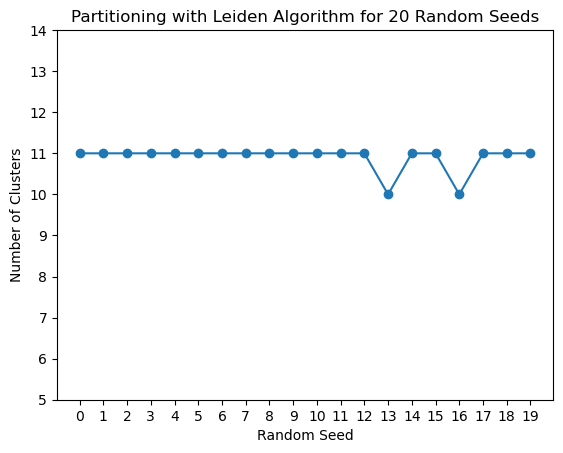

In [14]:
plt.plot(seeds, num_communities, marker='o')
plt.yticks(range(5,15))
plt.xticks(range(0,20))
plt.xlabel('Random Seed')
plt.ylabel('Number of Clusters')
plt.title('Partitioning with Leiden Algorithm for 20 Random Seeds')
plt.show()

Investigate the number of nodes for each seed's clusters

In [15]:
for seed, communities in zip(seeds, all_communities): # zip() function creates an iterator that will merge elements from two or more data sources into one
    print("Seed:", seed)
    for idx, community in enumerate(communities.communities):
        print("Community", idx+1, "Size:", len(community))

Seed: 0
Community 1 Size: 90
Community 2 Size: 63
Community 3 Size: 49
Community 4 Size: 37
Community 5 Size: 33
Community 6 Size: 33
Community 7 Size: 19
Community 8 Size: 9
Community 9 Size: 8
Community 10 Size: 3
Community 11 Size: 2
Seed: 1
Community 1 Size: 78
Community 2 Size: 64
Community 3 Size: 48
Community 4 Size: 36
Community 5 Size: 33
Community 6 Size: 33
Community 7 Size: 31
Community 8 Size: 9
Community 9 Size: 8
Community 10 Size: 3
Community 11 Size: 3
Seed: 2
Community 1 Size: 79
Community 2 Size: 65
Community 3 Size: 48
Community 4 Size: 37
Community 5 Size: 34
Community 6 Size: 33
Community 7 Size: 27
Community 8 Size: 9
Community 9 Size: 8
Community 10 Size: 3
Community 11 Size: 3
Seed: 3
Community 1 Size: 88
Community 2 Size: 64
Community 3 Size: 48
Community 4 Size: 37
Community 5 Size: 33
Community 6 Size: 32
Community 7 Size: 21
Community 8 Size: 9
Community 9 Size: 8
Community 10 Size: 3
Community 11 Size: 3
Seed: 4
Community 1 Size: 78
Community 2 Size: 65
Co

In [16]:
# better overview
table_nodes = {} # dictionary for cluster sizes

for seed, communities in zip(seeds, all_communities): # zip() function creates an iterator that merges elements from several data sources into one
    seed_name = f"Seed {seed}" # remember f-strings
    for clusnr, community in enumerate(communities.communities):
        community_name = f"Community {clusnr+1}"
        table_nodes.setdefault(community_name, {})[seed_name] = len(community)

df = pd.DataFrame(table_nodes) # dict into df

print(df)

         Community 1  Community 2  Community 3  Community 4  Community 5  \
Seed 0            90           63           49           37           33   
Seed 1            78           64           48           36           33   
Seed 2            79           65           48           37           34   
Seed 3            88           64           48           37           33   
Seed 4            78           65           48           36           33   
Seed 5            76           66           48           41           37   
Seed 6            80           64           49           37           35   
Seed 7            87           64           49           37           33   
Seed 8            80           64           49           37           35   
Seed 9            88           64           49           37           33   
Seed 10           88           64           49           37           33   
Seed 11           89           64           49           36           33   
Seed 12     

Decide on a seed

In [17]:
embeddedness_values = []

for c in all_communities: # all_communities contains the clusterings for all seeds
    embeddedness_value = evaluation.avg_embeddedness(G_RefNet, c)
    embeddedness_values.append(embeddedness_value)

df_embseeds = pd.DataFrame({"Embeddedness": embeddedness_values})



hub_values = []

for c in all_communities:
    hub_value = evaluation.hub_dominance(G_RefNet, c)
    hub_values.append(hub_value)

df_hub = pd.DataFrame({"Hub Dominance": hub_values})


zmod_values = []

for c in all_communities:
    zmod_value = evaluation.z_modularity(G_RefNet, c)
    zmod_values.append(zmod_value)

df_zmod = pd.DataFrame({"Modularity (Z-score-based)": zmod_values})


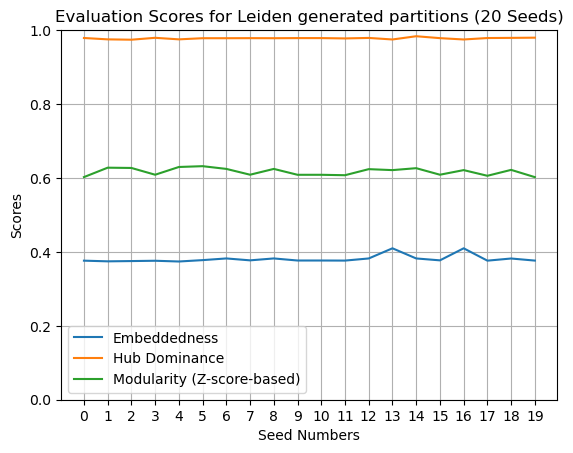

In [18]:
seeds = list(range(num_seeds))

embeddedness_scores = [c[2] for c in embeddedness_values] # taking the third value of the results (tuple)
hub_scores = [c[2] for c in hub_values]
modularity_scores = [c[2] for c in zmod_values]

plt.plot(seeds, embeddedness_scores, label='Embeddedness')
plt.plot(seeds, hub_scores, label='Hub Dominance')
plt.plot(seeds, modularity_scores, label='Modularity (Z-score-based)')

plt.xlabel('Seed Numbers')
plt.ylabel('Scores')
plt.title('Evaluation Scores for Leiden generated partitions (20 Seeds)')
plt.xticks(range(0,20)) # stops with 19
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.show()

In [19]:
coms = leiden_seed(G_RefNet, weights='weight', seed = 13) # seed = 13 seems to have a slightly higher embeddedness value for only 10 clusters

In [20]:
len(coms.communities)

10

In [21]:
coms.communities

[['WOS:A19647300A00002',
  'WOS:A1952UH81500008',
  'WOS:A1972L403600001',
  'WOS:A1985ATB3400002',
  'WOS:A1997WR58900004',
  'WOS:000185052600017',
  'MEDLINE:8792231',
  'WOS:000172396900002',
  'WOS:000225353900015',
  'WOS:000227701600036',
  'WOS:A19629703B00041',
  'WOS:A1981LX09600014',
  'WOS:A19617285A00001',
  'BCI:BCI19623900006027',
  'WOS:A1959XD03700005',
  'WOS:A1989T800800057',
  'WOS:A1977DR31800003',
  'WOS:000223798400013',
  'WOS:000187397400013',
  'WOS:000253156100024',
  'WOS:000087725300001',
  'WOS:000238739800001',
  'WOS:A1993KG65900026',
  'WOS:000178882900001',
  'WOS:000253846500074',
  'WOS:000232528900057',
  'WOS:000227984000018',
  'WOS:000226342000039',
  'WOS:000221101300013',
  'WOS:000236906000026',
  'WOS:000173321400003',
  'WOS:000224175000009',
  'WOS:A1973Q950000001',
  'WOS:A1996VW71200065',
  'WOS:000075118400001',
  'WOS:000232739000009',
  'WOS:000233319100023',
  'WOS:A1996VP75800008',
  'WOS:000187228500021',
  'WOS:000258591000039',
  

In [22]:
df_communities = pd.DataFrame()


for i, community in enumerate(coms.communities):
    df_communities[f'Community_{i+1}'] = pd.Series(community)


df_communities = df_communities.transpose()
# column that shows the size of each community
df_communities['Size'] = df_communities.apply(lambda row: row.count(), axis=1)

# View the DataFrame
df_communities




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,Size
Community_1,WOS:A19647300A00002,WOS:A1952UH81500008,WOS:A1972L403600001,WOS:A1985ATB3400002,WOS:A1997WR58900004,WOS:000185052600017,MEDLINE:8792231,WOS:000172396900002,WOS:000225353900015,WOS:000227701600036,WOS:A19629703B00041,WOS:A1981LX09600014,WOS:A19617285A00001,BCI:BCI19623900006027,WOS:A1959XD03700005,WOS:A1989T800800057,WOS:A1977DR31800003,WOS:000223798400013,WOS:000187397400013,WOS:000253156100024,WOS:000087725300001,WOS:000238739800001,WOS:A1993KG65900026,WOS:000178882900001,WOS:000253846500074,WOS:000232528900057,WOS:000227984000018,WOS:000226342000039,WOS:000221101300013,WOS:000236906000026,WOS:000173321400003,WOS:000224175000009,WOS:A1973Q950000001,WOS:A1996VW71200065,WOS:000075118400001,WOS:000232739000009,WOS:000233319100023,WOS:A1996VP75800008,WOS:000187228500021,WOS:000258591000039,WOS:000225416300002,WOS:000239601100003,WOS:000188260400014,WOS:000089039100001,WOS:000083169000008,WOS:A1996VD97200050,WOS:000167678600002,WOS:000183940600041,WOS:A1995RC19000042,WOS:000270818600036,WOS:000326585600035,WOS:000260938100008,WOS:A1993LV38300105,WOS:000073484300037,WOS:A1995QN29300020,WOS:000255327300009,WOS:000223246300016,WOS:A1995RP73800037,WOS:A1991GA52400020,WOS:A1984SK39700006,BCI:BCI199497521810,WOS:000274020500040,WOS:000340123500023,WOS:000248754200039,WOS:000254145200015,WOS:A1988P227500004,WOS:A1984SU47600030,WOS:A1995QV93000043,WOS:A1986E040500028,WOS:000182491600001,WOS:000187122500039,WOS:A1996UW55100004,WOS:000084013200056,WOS:000073415700097,WOS:A1952UH81100007,WOS:000305982900048,WOS:000224245900016,WOS:000086808800002,78
Community_2,WOS:000186094800010,WOS:000171017300008,WOS:A1997XM55000001,WOS:A1984SE48500007,WOS:000256866400003,WOS:000250064400006,WOS:000239869500001,WOS:000248635700005,WOS:000246190600008,WOS:000078067000046,MEDLINE:19194529,MEDLINE:19129924,WOS:000279341000021,WOS:000276344300006,WOS:000181410700011,MEDLINE:19543450,MEDLINE:19115011,WOS:000270799700038,MEDLINE:19352443,WOS:000220842500001,WOS:000269808300034,WOS:000250368200070,MEDLINE:19198667,000311837300002.31,WOS:A1977EE49800008,WOS:000304079500029,WOS:000234801500018,WOS:000209207100026,WOS:000331845700020,WOS:000299567900001,WOS:000419789500012,WOS:000209207300018,WOS:A1996UY95000055,WOS:000083871700002,WOS:000087725000001,WOS:000246262300001,WOS:000311666200044,000361488600009.6,WOS:000079997700004,WOS:000263120300003,WOS:000249141400001,WOS:000310441700001,WOS:000386762700007,WOS:000362952700021,WOS:000384570200006,CCC:000168816100004,WOS:000425314200001,WOS:000167812500015,WOS:000271807900019,WOS:000348103300001,WOS:000489867700001,WOS:000370606600001,WOS:000348104800001,WOS:000368191000001,WOS:000304197000010,WOS:000241031200039,WOS:000348206900001,WOS:000229835600006,WOS:000256824500012,MEDLINE:19198661,WOS:000209207300010,WOS:000393658900001,WOS:000467257000039,WOS:000348207000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64
Community_3,WOS:000083883300021,WOS:000208047200002,WOS:000245737500059,WOS:A1996UP43500059,WOS:A1996TU31400017,WOS:A1995RA60400031,WOS:A1996UQ65700051,WOS:000233319100002,WOS:A1985ABE5800027,WOS:000298323200011,WOS:000295899600021,WOS:000237698100002,WOS:000350097300045,WOS:A1992JD05300008,WOS:000242403800022,000395099500043.47,WOS:000174061700001,WOS:000076557300010,WOS:000300140600005,WOS:A1987L438200004,WOS:A19626729B00007,WOS:000355286600030,WOS:A1968A792100014,WOS:000370822200004,WOS:000358253400020,000548564900074.23,WOS:A1997YG15500010,WOS:A1997YG15500011,WOS:000170109100039,WOS:000493396600005,WOS:000400012300083,WOS:000345454400012,WOS:A1980JR59700002,WOS:000256233000031,WOS:000262208900017,WOS:A1959WC32500010,WOS:000336976000076,WOS:000379319900018,WOS:000214836400004,WOS:000254117400047,WOS:000248919200008,WOS:000243420500004,WOS:000239308600057,

In [23]:
df_communities.to_csv('refs_community_overview.csv')

In [24]:
id_to_title = refs.set_index('item_id_clear')['title_lower'].to_dict()

df_communities_with_titles = pd.DataFrame()

# titles instead of IDs
for i, community in enumerate(coms.communities):
    title_community = [id_to_title.get(node_id, "Unknown") for node_id in community]
    df_communities_with_titles[f'Community_{i+1}'] = pd.Series(title_community)

# Transpose
df_communities_with_titles = df_communities_with_titles.transpose()

# column that shows the size of each community
df_communities_with_titles['Size'] = df_communities_with_titles.apply(lambda row: row.count(), axis=1)

df_communities_with_titles




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,Size
Community_1,random walk models for spike activity of singl...,a quantitative description of membrane current...,excitatory and inhibitory interactions in loca...,comparative electrophysiology of pyramidal and...,model of global spontaneous activity and local...,the high-conductance state of neocortical neur...,"synthesis of models for excitable membranes, s...",fluctuating synaptic conductances recreate in ...,similar network activity from disparate circui...,single-column thalamocortical network model ex...,active pulse transmission line simulating nerv...,voltage oscillations in the barnacle giant mus...,impulses and physiological states in theoretic...,electro-physiology of a dendritic neuron model,branching dendritic trees and motoneuron membr...,oscillatory responses in cat visual-cortex exh...,dynamics of pattern formation in lateral-inhib...,which model to use for cortical spiking neurons?,how spike generation mechanisms determine the ...,dynamic i-v curves are reliable predictors of ...,dynamics of sparsely connected networks of exc...,a review of the integrate-and-fire neuron mode...,the highly irregular firing of cortical-cells ...,real-time computing without stable states: a n...,large-scale model of mammalian thalamocortical...,adaptive exponential integrate-and-fire model ...,highly nonrandom features of synaptic connecti...,a point process framework for relating neural ...,multiple neural spike train data analysis: sta...,weak pairwise correlations imply strongly corr...,the time-rescaling theorem and its application...,a quantitative map of the circuit of cat prima...,mathematical theory of functional dynamics of ...,chaos in neuronal networks with balanced excit...,chaotic balanced state in a model of cortical ...,a mechanism for cognitive dynamics: neuronal c...,signal propagation and logic gating in network...,gamma oscillation by synaptic inhibition in a ...,neuronal avalanches in neocortical circuits,spatio-temporal correlations and visual signal...,maximum likelihood estimation of cascade point...,predicting spike timing of neocortical pyramid...,simple model of spiking neurons,"neural excitability, spiking and bursting",fast global oscillations in networks of integr...,nature and precision of temporal coding in vis...,a novel spike distance,what determines the frequency of fast network ...,reliability of spike timing in neocortical neu...,how good are neuron models?,context-dependent computation by recurrent dyn...,firing patterns in the adaptive exponential in...,asynchronous states in networks of pulse-coupl...,the variable discharge of cortical neurons: im...,visual feature integration and the temporal co...,instantaneous correlation of excitation and in...,neuronal circuits of the neocortex,recurrent excitation in neocortical circuits,a model of a ca3 hippocampal pyramidal neuron ...,a model of neuronal bursting using 3 coupled 1...,"noise, neural codes and cortical organization",the asynchronous state in cortical circuits,neuronal dynamics: from single neurons to netw...,correlation between neural spike trains increa...,noise in the nervous system,chaos in random neural networks,neurons with graded response have collective c...,theory of orientation tuning in visual-cortex,neuronal population coding of movement direction,estimating a state-space model from point proc...,alternative to hand-tuning conductance-based m...,"type i membranes, phase resetting curves, and ...",stable propagation of synchronous spiking in c...,differential signaling via the same axon of ne...,currents carried by sodium and potassium ions ...,neural population dynamics during reaching,interneurons of the neocortical inhibitory system,lapicque's introduction of the integrate-and-f...,78
Community_2,mo

In [25]:
df_communities_with_titles.to_csv('community_titles_overview.csv')

Bubble Chart

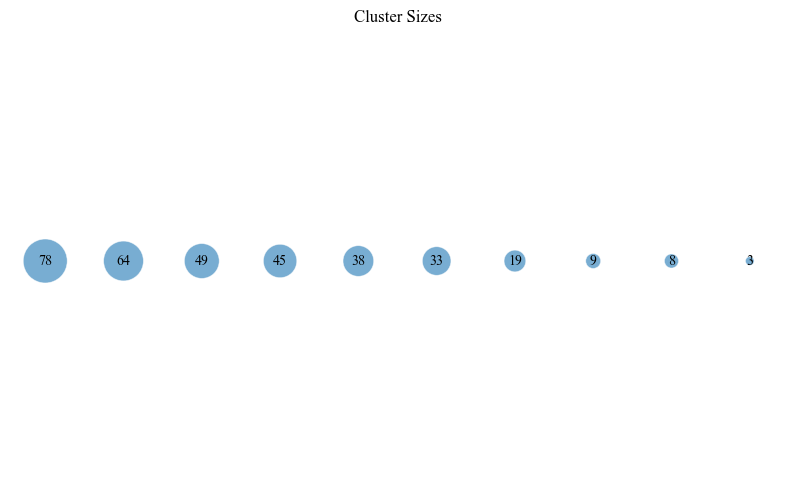

In [51]:
clusters = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 
            'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10']
sizes = df_communities_with_titles['Size'].tolist()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

# easier to compare and see
#norm_sizes = [size/max(sizes) * 1000 for size in sizes]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(clusters, [1]*10, s=norm_sizes, alpha=0.6, edgecolors="w", linewidth=0.5)

for i, txt in enumerate(sizes):
    ax.annotate(txt, (clusters[i], 1), fontsize=10, ha='center', va='center')

ax.axis('off')
ax.set_title('Cluster Sizes')
plt.show()


Pie Chart

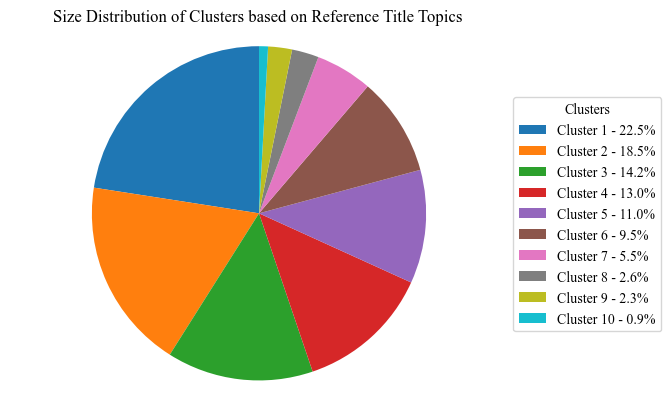

In [67]:
sizes = df_communities_with_titles['Size'].tolist()

# Cluster labels
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10']

# Percentages for the legend
percentages = [f"{(size/sum(sizes))*100:.1f}%" for size in sizes]
legend_labels = [f"{label} - {percentage}" for label, percentage in zip(labels, percentages)]

fig, ax = plt.subplots()
wedges, _ = ax.pie(sizes, startangle=90)

ax.axis('equal')  # Equal aspect ratio for circle really needed? Shifts Title to the right

# legend on the side
ax.legend(wedges, legend_labels, title="Clusters", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Size Distribution of Clusters based on Reference Title Topics")
plt.show()

More colorblind-friendly colors

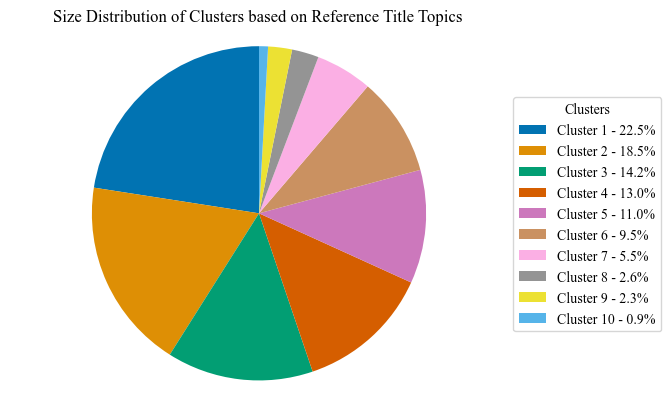

In [69]:
palette = sns.color_palette("colorblind", 10) 

sizes = df_communities_with_titles['Size'].tolist()

# Cluster labels
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10']

# percentages for the legend
percentages = [f"{(size/sum(sizes))*100:.1f}%" for size in sizes]
legend_labels = [f"{label} - {percentage}" for label, percentage in zip(labels, percentages)]

fig, ax = plt.subplots()
wedges, _ = ax.pie(sizes, colors=palette, startangle=90)

ax.axis('equal')  # Equal aspect ratio needed for circle or not?

# legend on the side
ax.legend(wedges, legend_labels, title="Clusters", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Size Distribution of Clusters based on Reference Title Topics")
plt.savefig('piechart_reftitle_topics.png', bbox_inches='tight') # Save as png with tight bounding box; needs to go here to not save empty plot
plt.show()

In [68]:
plt.savefig('piechart_reftitle_topics.png', bbox_inches='tight') # Save as png with tight bounding box

<Figure size 640x480 with 0 Axes>

Central References based on Centrality Measures

In [26]:
# Function to calculate the top 10 authors by centrality
def top_10_central(G, centrality_type):
    """
    Function to calculate the top 10 most central authors in given network graph.

    Parameters:
    G (Graph): The network graph
    centrality_type (str): The type of centrality to calculate ('betweenness' or 'closeness')

    Returns:
    list: Sorted list of tuples with the top 10 authors and their centrality score
    """
    if centrality_type == 'betweenness': # Check type of centrality metric to calculate
        centrality_dict = nx.betweenness_centrality(G) # Betweenness ...
    elif centrality_type == 'closeness':
        centrality_dict = nx.closeness_centrality(G) # Closeness ...
    else:
        return "Invalid centrality type" # added this to avoid errors
        
    sorted_centrality = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    return sorted_centrality



NOTE: Betweenness Centrality has a runtime complexity of 
O(nm) for unweighted graphs and O(nm+n^2logn) for weighted graphs (which is here), where 
n is the number of nodes and m is the number of edges. Therefore, this step takes a lot of time to compute!

In [27]:
# Top 10 central nodes based on betweenness centrality for both graphs
top_10_betweenness = top_10_central(G_RefNet, 'betweenness')




In [28]:
top_10_betweenness

[('WOS:A1952UH81500008', 0.06208399388851024),
 ('WOS:A1982NL32300028', 0.02173424405858895),
 ('WOS:000208047200002', 0.021110619155761682),
 ('WOS:A1997XM55000001', 0.01919345975905734),
 ('WOS:A1997WN12300029', 0.019161529551345476),
 ('WOS:000188260400014', 0.017536834002594866),
 ('WOS:000234801500018', 0.014847003733922746),
 ('WOS:A1972L403600001', 0.012466641357153533),
 ('WOS:000263556500012', 0.011666863256800487),
 ('WOS:000228889200019', 0.011358274351196497)]

In [29]:
# Top 10 central nodes based on closeness centrality for both graphs
top_10_closeness = top_10_central(G_RefNet, 'closeness')

In [30]:
top_10_closeness

[('WOS:A1952UH81500008', 0.7683741648106904),
 ('WOS:000188260400014', 0.7128099173553719),
 ('WOS:A1982NL32300028', 0.6913827655310621),
 ('WOS:A1997WN12300029', 0.675146771037182),
 ('WOS:000087725300001', 0.673828125),
 ('WOS:000234801500018', 0.6686046511627907),
 ('WOS:000362952700021', 0.6647398843930635),
 ('000311837300002.31', 0.6546489563567363),
 ('WOS:A1972L403600001', 0.6509433962264151),
 ('WOS:A1997WR58900004', 0.6436567164179104)]

In [31]:
degree_dict = dict(G_RefNet.degree()) # all nodes' degrees

# Sort nodes by degree in descending order
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

top_10_degree = sorted_degree[:10]

# into df
df_top_10_degree = pd.DataFrame(top_10_degree, columns=['Node (Reference ID)', 'Degree'])

# reference titles to df
top_10_nodes = [node for node, _ in top_10_degree]
df_top_10_degree['Reference Title'] = df_top_10_degree['Node (Reference ID)'].map(
    refs.set_index('item_id_clear')['ref_item_title'].to_dict()
)




In [32]:
pd.set_option('display.max_colwidth', None)
df_top_10_degree

,Node (Reference ID),Degree,Reference Title
0,WOS:A1952UH81500008,241,A QUANTITATIVE DESCRIPTION OF MEMBRANE CURRENT AND ITS APPLICATION TO CONDUCTION AND EXCITATION IN NERVE
1,WOS:000188260400014,212,Simple model of spiking neurons
2,WOS:A1982NL32300028,197,NEURAL NETWORKS AND PHYSICAL SYSTEMS WITH EMERGENT COLLECTIVE COMPUTATIONAL ABILITIES
3,WOS:A1997WN12300029,185,A neural substrate of prediction and reward
4,WOS:000087725300001,184,Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons
5,WOS:000234801500018,180,The Blue Brain Project
6,WOS:000362952700021,177,Reconstruction and Simulation of Neocortical Microcircuitry
7,000311837300002.31,169,NEST (NEural Simulation Tool)
8,WOS:A1972L403600001,166,EXCITATORY AND INHIBITORY INTERACTIONS IN LOCALIZED POPULATIONS OF MODEL NEURONS
9,WOS:000208047200002,166,Distributed Hierarchical Processing in the Primate Cerebral Cortex


Find which cluster the nodes belong to 

In [33]:
clusters = coms.communities

# 2. Map each node to its cluster
node_to_cluster = {}
for cluster_index, cluster in enumerate(clusters):
    for node in cluster:
        node_to_cluster[node] = cluster_index

# 3. Add cluster assignment to your DataFrame
df_top_10_degree['Cluster'] = df_top_10_degree['Node (Reference ID)'].map(node_to_cluster)

In [34]:
df_top_10_degree

,Node (Reference ID),Degree,Reference Title,Cluster
0,WOS:A1952UH81500008,241,A QUANTITATIVE DESCRIPTION OF MEMBRANE CURRENT AND ITS APPLICATION TO CONDUCTION AND EXCITATION IN NERVE,0
1,WOS:000188260400014,212,Simple model of spiking neurons,0
2,WOS:A1982NL32300028,197,NEURAL NETWORKS AND PHYSICAL SYSTEMS WITH EMERGENT COLLECTIVE COMPUTATIONAL ABILITIES,3
3,WOS:A1997WN12300029,185,A neural substrate of prediction and reward,3
4,WOS:000087725300001,184,Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons,0
5,WOS:000234801500018,180,The Blue Brain Project,1
6,WOS:000362952700021,177,Reconstruction and Simulation of Neocortical Microcircuitry,1
7,000311837300002.31,169,NEST (NEural Simulation Tool),1
8,WOS:A1972L403600001,166,EXCITATORY AND INHIBITORY INTERACTIONS IN LOCALIZED POPULATIONS OF MODEL NEURONS,0
9,WOS:000208047200002,166,Distributed Hierarchical Processing in the Primate Cerebral Cortex,2


Note: The most influential references are not necessarily in different clusters, but in the biggest clusters

Centrality Measures

In [35]:
def find_title(item_id_clear, refs):
    """
    Search the refs DataFrame for the ref_item_title associated with the given item_id_clear.

    Parameters:
    item_id_clear (str): The item ID to search for
    refs (DataFrame): The DataFrame containing reference information

    Returns:
    str: The title associated with the given item ID, or 'Unknown' if not found
    """
    matching_row = refs[refs['item_id_clear'] == item_id_clear]
    
    if matching_row.empty:
        return 'Unknown'
    else:
        return matching_row.iloc[0]['ref_item_title']

In [36]:
titles_betweenness = [find_title(x[0], refs) for x in top_10_betweenness]
# Add titles for Closeness
titles_closeness = [find_title(x[0], refs) for x in top_10_closeness]

# Combine into df
df_top_10_centralities = pd.DataFrame({
    'Top 10 Betweenness': [f"{x[0]} ({x[1]:.3f})" for x in top_10_betweenness],
    'Title (Betweenness)': titles_betweenness,
    'Top 10 Closeness': [f"{x[0]} ({x[1]:.3f})" for x in top_10_closeness],
    'Title (Closeness)': titles_closeness,
})

In [37]:
pd.set_option('display.max_colwidth', None)
df_top_10_centralities

,Top 10 Betweenness,Title (Betweenness),Top 10 Closeness,Title (Closeness)
0,WOS:A1952UH81500008 (0.062),A QUANTITATIVE DESCRIPTION OF MEMBRANE CURRENT AND ITS APPLICATION TO CONDUCTION AND EXCITATION IN NERVE,WOS:A1952UH81500008 (0.768),A QUANTITATIVE DESCRIPTION OF MEMBRANE CURRENT AND ITS APPLICATION TO CONDUCTION AND EXCITATION IN NERVE
1,WOS:A1982NL32300028 (0.022),NEURAL NETWORKS AND PHYSICAL SYSTEMS WITH EMERGENT COLLECTIVE COMPUTATIONAL ABILITIES,WOS:000188260400014 (0.713),Simple model of spiking neurons
2,WOS:000208047200002 (0.021),Distributed Hierarchical Processing in the Primate Cerebral Cortex,WOS:A1982NL32300028 (0.691),NEURAL NETWORKS AND PHYSICAL SYSTEMS WITH EMERGENT COLLECTIVE COMPUTATIONAL ABILITIES
3,WOS:A1997XM55000001 (0.019),The NEURON simulation environment,WOS:A1997WN12300029 (0.675),A neural substrate of prediction and reward
4,WOS:A1997WN12300029 (0.019),A neural substrate of prediction and reward,WOS:000087725300001 (0.674),Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons
5,WOS:000188260400014 (0.018),Simple model of spiking neurons,WOS:000234801500018 (0.669),The Blue Brain Project
6,WOS:000234801500018 (0.015),The Blue Brain Project,WOS:000362952700021 (0.665),Reconstruction and Simulation of Neocortical Microcircuitry
7,WOS:A1972L403600001 (0.012),EXCITATORY AND INHIBITORY INTERACTIONS IN LOCALIZED POPULATIONS OF MODEL NEURONS,000311837300002.31 (0.655),Nest (neural simulation tool)
8,WOS:000263556500012 (0.012),Complex brain networks: graph theoretical analysis of structural and functional systems,WOS:A1972L403600001 (0.651),EXCITATORY AND INHIBITORY INTERACTIONS IN LOCALIZED POPULATIONS OF MODEL NEURONS
9,WOS:000228889200019 (0.011),Differences in potentials and excitability properties in simulated cases of demyelinating neuropathies. Part II. Paranodal demyelination,WOS:A1997WR58900004 (0.644),Model of global spontaneous activity and local structured activity during delay periods in the cerebral cortex


Add the publication years of the references found

In [38]:
# Find the publication year of a given reference ID
def find_pubyear(item_id, refs_df):
    pubyear = refs_df[refs_df['item_id_clear'] == item_id]['ref_pubyear'].iloc[0]
    return pubyear

# Find the corresponding publication years for the top 10 betweenness and closeness entries
pubyears_betweenness = [find_pubyear(x[0], refs) for x in top_10_betweenness]
pubyears_closeness = [find_pubyear(x[0], refs) for x in top_10_closeness]

# Add these to your existing DataFrame
df_top_10_centralities['PubYear (Betweenness)'] = pubyears_betweenness
df_top_10_centralities['PubYear (Closeness)'] = pubyears_closeness

In [39]:
df_top_10_centralities

,Top 10 Betweenness,Title (Betweenness),Top 10 Closeness,Title (Closeness),PubYear (Betweenness),PubYear (Closeness)
0,WOS:A1952UH81500008 (0.062),A QUANTITATIVE DESCRIPTION OF MEMBRANE CURRENT AND ITS APPLICATION TO CONDUCTION AND EXCITATION IN NERVE,WOS:A1952UH81500008 (0.768),A QUANTITATIVE DESCRIPTION OF MEMBRANE CURRENT AND ITS APPLICATION TO CONDUCTION AND EXCITATION IN NERVE,1952.0,1952.0
1,WOS:A1982NL32300028 (0.022),NEURAL NETWORKS AND PHYSICAL SYSTEMS WITH EMERGENT COLLECTIVE COMPUTATIONAL ABILITIES,WOS:000188260400014 (0.713),Simple model of spiking neurons,1982.0,2003.0
2,WOS:000208047200002 (0.021),Distributed Hierarchical Processing in the Primate Cerebral Cortex,WOS:A1982NL32300028 (0.691),NEURAL NETWORKS AND PHYSICAL SYSTEMS WITH EMERGENT COLLECTIVE COMPUTATIONAL ABILITIES,1991.0,1982.0
3,WOS:A1997XM55000001 (0.019),The NEURON simulation environment,WOS:A1997WN12300029 (0.675),A neural substrate of prediction and reward,1997.0,1997.0
4,WOS:A1997WN12300029 (0.019),A neural substrate of prediction and reward,WOS:000087725300001 (0.674),Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons,1997.0,2000.0
5,WOS:000188260400014 (0.018),Simple model of spiking neurons,WOS:000234801500018 (0.669),The Blue Brain Project,2003.0,2006.0
6,WOS:000234801500018 (0.015),The Blue Brain Project,WOS:000362952700021 (0.665),Reconstruction and Simulation of Neocortical Microcircuitry,2006.0,2015.0
7,WOS:A1972L403600001 (0.012),EXCITATORY AND INHIBITORY INTERACTIONS IN LOCALIZED POPULATIONS OF MODEL NEURONS,000311837300002.31 (0.655),Nest (neural simulation tool),1972.0,2007.0
8,WOS:000263556500012 (0.012),Complex brain networks: graph theoretical analysis of structural and functional systems,WOS:A1972L403600001 (0.651),EXCITATORY AND INHIBITORY INTERACTIONS IN LOCALIZED POPULATIONS OF MODEL NEURONS,2009.0,1972.0
9,WOS:000228889200019 (0.011),Differences in potentials and excitability properties in simulated cases of demyelinating neuropathies. Part II. Paranodal demyelination,WOS:A1997WR58900004 (0.644),Model of global spontaneous activity and local structured activity during delay periods in the cerebral cortex,2005.0,1997.0


PageRank

In [40]:
pagerank_dict = nx.pagerank(G_RefNet)
sorted_pagerank = sorted(pagerank_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# corresponding titles and publication years
titles_pagerank = [refs[refs['item_id_clear'] == x[0]].iloc[0]['ref_item_title'] for x in sorted_pagerank]
pubyears_pagerank = [refs[refs['item_id_clear'] == x[0]].iloc[0]['ref_pubyear'] for x in sorted_pagerank]

# top 10 nodes based on PageRank
import pandas as pd
df_top_10_pagerank = pd.DataFrame({
    'Top 10 PageRank': [f"{x[0]} ({x[1]:.3f})" for x in sorted_pagerank],
    'Title (PageRank)': titles_pagerank,
    'PubYear (PageRank)': pubyears_pagerank
})

In [41]:
df_top_10_pagerank

,Top 10 PageRank,Title (PageRank),PubYear (PageRank)
0,MEDLINE:19194529 (0.009),PyNN: A Common Interface for Neuronal Network Simulators.,2008.0
1,000311837300002.31 (0.009),Nest (neural simulation tool),2007.0
2,WOS:000336976000076 (0.007),Performance-optimized hierarchical models predict neural responses in higher visual cortex,2014.0
3,WOS:000345454400012 (0.007),"Deep Supervised, but Not Unsupervised, Models May Explain IT Cortical Representation",2014.0
4,MEDLINE:19115011 (0.007),Brian: a simulator for spiking neural networks in python.,2008.0
5,WOS:000279341000021 (0.007),NeuroML: A Language for Describing Data Driven Models of Neurons and Networks with a High Degree of Biological Detail,2010.0
6,MEDLINE:19198667 (0.006),PyNEST: A Convenient Interface to the NEST Simulator.,2008.0
7,WOS:000087725300001 (0.006),Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons,2000.0
8,WOS:000250064400006 (0.006),Simulation of networks of spiking neurons: A review of tools and strategies,2007.0
9,WOS:000311977900005 (0.006),Canonical Microcircuits for Predictive Coding,2012.0


In [42]:
print(G_RefNet.number_of_nodes(), G_RefNet.number_of_edges())


346 13237


Eigenvector Centrality

In [43]:
eigenvector_centrality_dict = nx.eigenvector_centrality(G_RefNet)

#top 10 nodes based on Eigenvector centrality
sorted_eigenvector = sorted(eigenvector_centrality_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Find the corresponding titles and publication years
titles_eigenvector = [refs[refs['item_id_clear'] == x[0]].iloc[0]['ref_item_title'] for x in sorted_eigenvector]
pubyears_eigenvector = [refs[refs['item_id_clear'] == x[0]].iloc[0]['ref_pubyear'] for x in sorted_eigenvector]

#top 10 nodes based on Eigenvector centrality
df_top_10_eigenvector = pd.DataFrame({
    'Top 10 Eigenvector': [f"{x[0]} ({x[1]:.3f})" for x in sorted_eigenvector],
    'Title (Eigenvector)': titles_eigenvector,
    'PubYear (Eigenvector)': pubyears_eigenvector
})

In [44]:
df_top_10_eigenvector

,Top 10 Eigenvector,Title (Eigenvector),PubYear (Eigenvector)
0,WOS:A1952UH81500008 (0.140),A QUANTITATIVE DESCRIPTION OF MEMBRANE CURRENT AND ITS APPLICATION TO CONDUCTION AND EXCITATION IN NERVE,1952.0
1,WOS:000188260400014 (0.129),Simple model of spiking neurons,2003.0
2,WOS:000087725300001 (0.118),Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons,2000.0
3,WOS:000362952700021 (0.116),Reconstruction and Simulation of Neocortical Microcircuitry,2015.0
4,WOS:A1982NL32300028 (0.111),NEURAL NETWORKS AND PHYSICAL SYSTEMS WITH EMERGENT COLLECTIVE COMPUTATIONAL ABILITIES,1982.0
5,000311837300002.31 (0.110),Nest (neural simulation tool),2007.0
6,WOS:000234801500018 (0.110),The Blue Brain Project,2006.0
7,WOS:A1997WN12300029 (0.104),A neural substrate of prediction and reward,1997.0
8,WOS:000223798400013 (0.104),Which model to use for cortical spiking neurons?,2004.0
9,MEDLINE:19194529 (0.103),PyNN: A Common Interface for Neuronal Network Simulators.,2008.0


Save Network with clusters and weights as gexf

In [45]:
for cluster_id, cluster_nodes in enumerate(clusters):
    for node in cluster_nodes:
        G_RefNet.nodes[node]['cluster'] = cluster_id


nx.write_gexf(G_RefNet, "RefNet_with_clusters.gexf")

Triadic Closures?

Number of average citations

In [46]:
citation_counts = refs.groupby('item_id_clear').agg(num_citations=('item_id_citing', 'nunique'))

# Calculate the average
average_citations = citation_counts['num_citations'].mean()

print(f"Average number of citations per reference: {average_citations:.2f}")

Average number of citations per reference: 16.92
